# Pruebas de codigo con [OpenAir](https://davidcarslaw.github.io/openair/reference/index.html) y [Saqgetr](https://github.com/skgrange/saqgetr)

> [Configuracion del notebook](#config)
>
> [Leer los datos de fichero](#read)
>
> [Estaciones de españa](#espanha)
>    * [Datos de las estaciones de ```saqgetr```](#estacionesSaqgetr)
>    * [Datos geograficos de las estaciones](#estacionGeo)
>
> [Estudio de los Datos](#stdio)
>    * [Resolucion de 1 dia](#resody)
>    *   [x] [Probando otra forma](#prueba)
>    * [Resolucion de 1 semana](#resowk)
>    * [Resolucion de 1 mes](#resoms)
>
> [Analisis de los Datos](#analyData)
>    * [Theil-Sen function](#theilSen)
>    * [funcion `lm`](#lm)
>
>[Guardas Datos en xlsx](#save)

## Configuracion del notebook <a id="config"></a>

Ajustes especificos para controlar la apariencia de las graficas en jupyter lab

In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

Cargamos todos los paquetes necesarios para ejecutar el notebook

In [2]:
suppressMessages(library(saqgetr))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(worldmet))

# En lugar de cargar el paquete openair se utiliza el ggopenair,
# otro paquete desarrollado por el mismo que Openair con el objetivo de 
# utilizar ggplot2 en lugar de lattice para la representaciones graficas
#
#suppressMessages(library(openair))
suppressMessages(library(ggopenair)) 


suppressMessages(library(gridExtra))
suppressMessages(library(mblm))

Inicializamos ciertas variables con los parametros de estudio

In [3]:
# contaminantes a estudiar
pollutants <- c("no", "no2", "o3", "pm10")

# fechas de inicio y final de toma de datos
start_dt <- ymd_hms("2010-01-01 00:00:00")
end_dt <- ymd_hms("2020-10-01 00:00:00")

# fecha de inicio de confinamiento
lckdwn_strt <- ymd_hms("2020-03-14 00:00:00")

## Leer los datos de fichero <a id="read"></a>

Se pueden extraer directamente los datos ya seleccionados de las estaciones de estudio y los datos de la calidad del aire de los archivos `../data/csv/dataAQV.csv` y `../data/csv/estaciones.csv` respectivamente. Si no se tienen dichos archivos o se quieren modificar los parametros de estudio se ejecutara la seccion [Estaciones de España](#espanha)

In [4]:
#``` R
if (file.exists("../data/csv/estaciones.csv")) {
    sites <- read.csv("../data/csv/sitesAQ.csv")
}
head(sites)
#```

site    variable period unit   date_start          date_end           
1 es1271a pm10     day    ug.m-3 2005-01-01 00:00:00 2012-12-31 00:00:00
2 es1271a pm10     hour   ug.m-3 2005-01-01 00:00:00 2012-12-31 23:00:00
3 es1271a o3       day    ug.m-3 2002-01-01 00:00:00 2012-12-31 00:00:00
4 es1271a o3       dymax  ug.m-3 2002-01-01 00:00:00 2012-12-31 00:00:00
5 es1271a o3       hour   ug.m-3 2002-01-01 00:00:00 2012-12-31 23:00:00
6 es1271a o3       hour8  ug.m-3 2002-01-01 00:00:00 2012-12-31 23:00:00
  Municipio Población Estación.tráfico numData latitude longitude meteoCode   
1 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999
2 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999
3 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999
4 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999
5 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999
6 Gijón     271782    ARGENTINA        412000  43.5388  -5.6989   080140-99999

In [7]:
#``` R
if (file.exists("../data/csv/dataAQV.csv")) {
    dataAQV <- read.csv("../data/csv/dataAQV.csv")
    
    # Convert date to datetime format
    dataAQV$date <- ymd_hms(dataAQV$date)
}
head(dataAQV)
#```

X date                date_end            site    variable process summary
1 1 2017-01-01 01:00:00 2017-01-01 02:00:00 es0041a pm10     115268  1      
2 2 2017-01-01 02:00:00 2017-01-01 03:00:00 es0041a pm10     115268  1      
3 3 2017-01-01 03:00:00 2017-01-01 04:00:00 es0041a pm10     115268  1      
4 4 2017-01-01 04:00:00 2017-01-01 05:00:00 es0041a pm10     115268  1      
5 5 2017-01-01 05:00:00 2017-01-01 06:00:00 es0041a pm10     115268  1      
6 6 2017-01-01 06:00:00 2017-01-01 07:00:00 es0041a pm10     115268  1      
  validity unit   value
1 1        ug.m-3 39   
2 1        ug.m-3 27   
3 1        ug.m-3 18   
4 1        ug.m-3 17   
5 1        ug.m-3 17   
6 1        ug.m-3 15

## Estaciones de España <a id="espanha"></a>

### Datos geograficos de las estaciones <a id="estacionGeo"></a>

Seleccionamos aquellas estaciones que se encuentren en un núcleo con una
población mayor o igual a cien mil habitantes `poblacion >= 100 000 hab`.

En la hoja 8 `ciudades-100000-A-JA` de la base de datos de poblaciones (`estaciones-CA.xlsx`) aparecen todas las estaciones de trafico de las ciudades de mas de 100000 habitantes con sus nombres.

In [4]:
# Loading
library("readxl")

file <- "../data/xlsx/estaciones-CA-JA.xlsx"
sheets <- c("todas", "traffic", "traffic-urban", "traffic-urban-2020",
            "traffic-suburban", "traffic-suburban-2020",
            "ciudades-100000", "ciudades-100000-A")
# xlsx files
sites.100mil <- read_excel(file, sheet=sheets[8])

In [5]:
head(sites.100mil)

Municipio         Población Estación tráfico  Código estación
1 A Coruña          245711    CORLAB 1          es1138a        
2 Alcalá de Henares 195649    Alcalá de Henares es1563a        
3 Alcobendas        117040    Alcobendas        es1564a        
4 Alicante          334887    Florida-Babel     es1915a        
5 Alicante          334888    ALACANT-EL PLÁ    es1635a        
6 Almería           198533    MEDITERRÁNEO      es1393a        
  Nº estaciones Ecolog Nº estaciones tráfico
1 4                    1                    
2 0                    1                    
3 0                    1                    
4 3                    1                    
5 3                    1                    
6 0                    1                    
  Observaciones                                                       
1 Es Riazor o Santa Margarida, revisar. Datos sólo hasta 2018. REVISAR
2 NA                                                                  
3 NA                                                                  
4 Urban background. Not traffic                                       
5 Esta es de tráfico                                                  
6 NA

### Datos de las estaciones de `saqgetr` <a id="estacionesSaqgetr"></a>

Importamos la informacion de las estaciones de calidad de aire de españa obtenidas de la base de datos y filtramos segun los criterios de estudio.

| Variable | Valores |
|-------|-----------|
|Contaminantes| $NO$, $NO_2$, $O_3$, $PM_{10}$|
|Fecha Inicio| 01 Enero 2015 |
|Fecha Final | 31 Diciembre 2020 |
| Site Type | traffic |
|site area | urban |

In [5]:
# obtener datos de CA de España. Salen los códigos de las estaciones
# de Calidad de aire (941)
spain.sites <- get_saq_sites() %>%
    filter(country == "spain",
           site %in% sites.100mil$"Código estación",
           site_type == "traffic",
           site_area == "urban",
           date_start <= start_dt,
           date_end >= end_dt,
           ) %>%
    select(site, site_name, latitude, longitude, elevation, 
           country, site_type, site_area, date_start, date_end)

In [6]:
removed.sites <- nrow(sites.100mil) - nrow(spain.sites)

print(paste("Se han eliminado", removed.sites, "estaciones"))
print(paste("Quedan", nrow(spain.sites), "estaciones para el estudio"))

[1] "Se han eliminado 25 estaciones"
[1] "Quedan 54 estaciones para el estudio"


Agrupamos en un solo data.frame toda la informacion relevante de las estaciones de estudio

In [7]:
sites.info <- get_saq_processes() %>%
    filter(site %in% spain.sites$site,
           variable %in% pollutants,
           date_start <= start_dt,
           #date_end >= end_dt,
          ) %>%
    select(process, site, variable, variable_long, 
           period, unit, observation_count
          )

sites.geo <- sites.100mil %>%
    select("Municipio", "Población", 
           "Estación tráfico", "Código estación") %>%
    rename(site = "Código estación",)

sites <- merge(x = sites.info, y = sites.geo, by = "site", all.x = TRUE)
sites <- merge(x = sites, y = spain.sites, by = "site", all.x = TRUE)

In [8]:
head(sites)

site    process variable variable_long          period unit  
1 es0041a 31140   no2      Nitrogen dioxide (air) day    ug.m-3
2 es0110a 31281   o3       Ozone (air)            day    ug.m-3
3 es0110a 31282   o3       Ozone (air)            dymax  ug.m-3
4 es0110a 31283   o3       Ozone (air)            hour   ug.m-3
5 es0110a 31284   o3       Ozone (air)            hour8  ug.m-3
6 es0110a 31285   no2      Nitrogen dioxide (air) day    ug.m-3
  observation_count Municipio Población Estación tráfico   site_name         
1   151             Bilbao    346843    María Diaz de Haro DIRECCIÓN DE SALUD
2  4092             Bilbao     24350    Erandio            ERANDIO           
3  4095             Bilbao     24350    Erandio            ERANDIO           
4 94149             Bilbao     24350    Erandio            ERANDIO           
5 97891             Bilbao     24350    Erandio            ERANDIO           
6  5324             Bilbao     24350    Erandio            ERANDIO           
  latitude longitude elevation country site_type site_area date_start
1 43.25883 -2.94565  32        spain   traffic   urban     1986-04-01
2 43.30268 -2.97724   4        spain   traffic   urban     1997-01-01
3 43.30268 -2.97724   4        spain   traffic   urban     1997-01-01
4 43.30268 -2.97724   4        spain   traffic   urban     1997-01-01
5 43.30268 -2.97724   4        spain   traffic   urban     1997-01-01
6 43.30268 -2.97724   4        spain   traffic   urban     1997-01-01
  date_end           
1 2021-01-15 23:00:00
2 2021-01-15 23:00:00
3 2021-01-15 23:00:00
4 2021-01-15 23:00:00
5 2021-01-15 23:00:00
6 2021-01-15 23:00:00

## Estudio de los Datos <a id="stdio"></a>

In [6]:
suppressMessages(dataAQV <- get_saq_observations(
    site = levels(as.factor(sites$site))[2:5],
    variable = pollutants,
    valid_only = TRUE,
    start = start_dt,
    end = end_dt,
    verbose = TRUE
))


El paquete `saqgetr` nos permite 'limpiar' los datos, obteniendo directamente los datos con una resolucion horaria o diaria. Ademas, esta funcion permite mediante el atributo `spread=False` remodelar el dataframe pivotando las columnas `variable` y `value`, obteniendo un dataframe con los contamiantes por columna.

$$
\begin{vmatrix}
\textbf{site} & \textbf{variable} & \textbf{value} \\
es123a & no2 & 20.323 \\ 
es123a & 03 & 40.545 \\ 
es123a & pm10 & 60.323 \\ 
... & ... & ... \\ 
\end{vmatrix}
\Rightarrow
\begin{vmatrix}
\textbf{site} & \textbf{no2} & \textbf{03} & \textbf{pm10} \\
es123a & 20.323 & 40.545 & 60.323 \\ 
es123a & 20.323 & 40.545 & 60.323 \\ 
es123a & 20.323 & 40.545 & 60.323 \\ 
... & ... & ... & ... 
\end{vmatrix}
$$

``` R
dataAQV.cln <- saq_clean_observations(dataAQV,
                                      summary = "hour",
                                      #valid_only = TRUE,
                                      #spread = TRUE,
                                     )
```

No obstante, no te permite trabajar con otra resolucion que no sea horaria o diaria por lo que he creado dos funciones `pivot.by.pollut` y `group.by.date` para obtener las mismas transformaciones pero con la resolucion que quiera. Esto lo he hecho solo con el objetivo de familiarizarme con los datos.

Las funciones se pueden encontrar en el script `../src/funciones.R`

In [8]:
source("../src/funciones.R")

### Resolucion de 1 dia <a id="resody"></a>

In [11]:
group.day <- group.by.date(dataAQV, by="day", FUN="mean")

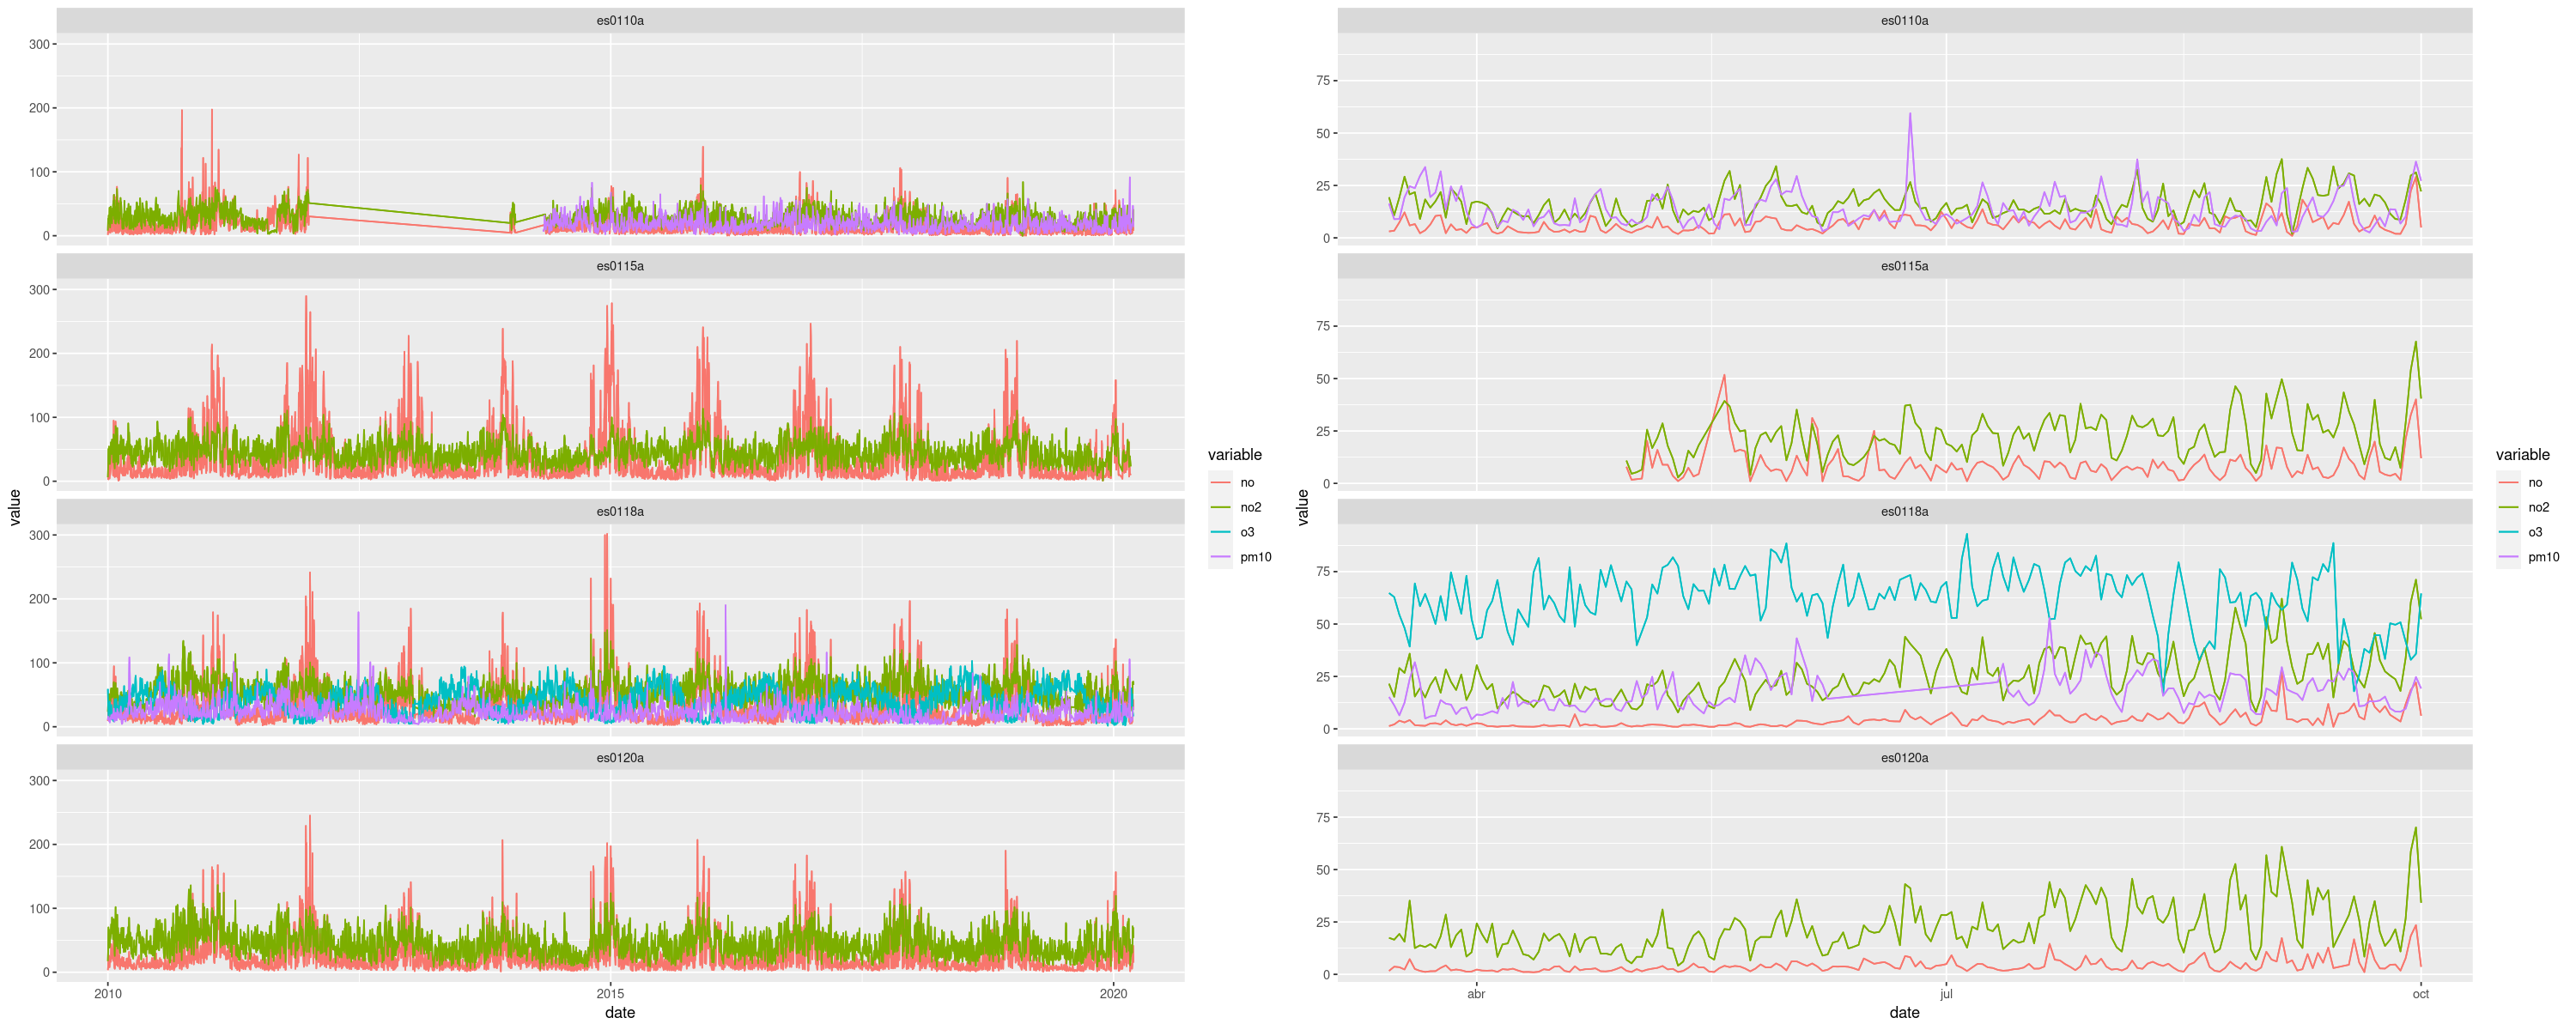

In [12]:
preCOVID <- ggplot(data = group.day[group.day$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.day[group.day$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

#### Probando otra forma <a id="prueba"></a>

In [13]:
group.test.hr <- group.by.date(dataAQV, by="8hour", FUN="mean")

group.test.dy <- group.by.date(group.test.hr, by="day", FUN="max")

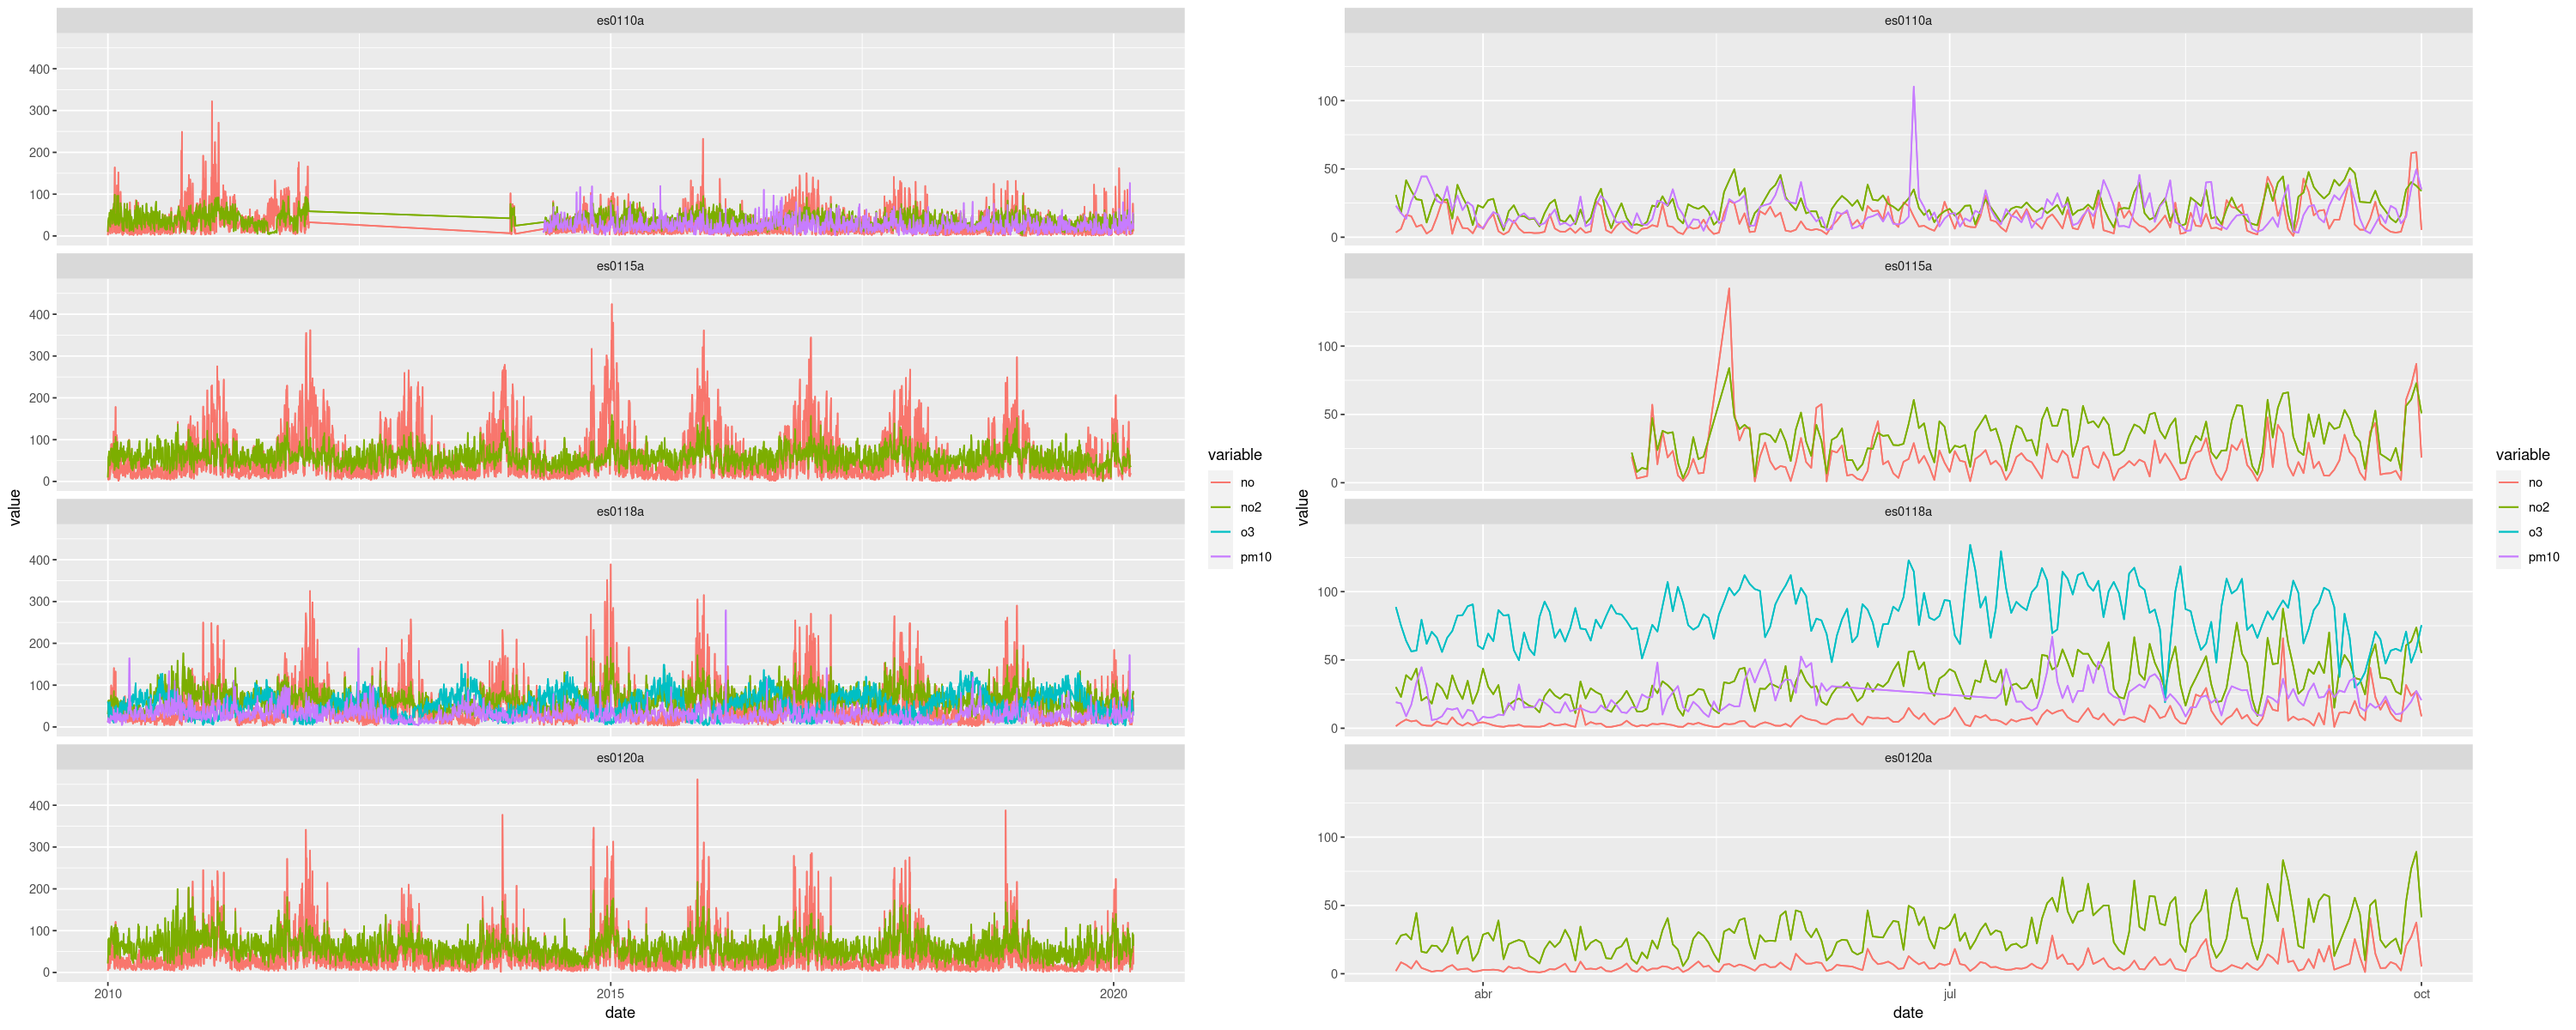

In [14]:
preCOVID <- ggplot(data = group.test.dy[group.test.dy$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.test.dy[group.test.dy$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

### Resolucion de 1 semana <a id="resowk"></a>

In [11]:
group.wk <- group.by.date(dataAQV, by="week", FUN="mean")

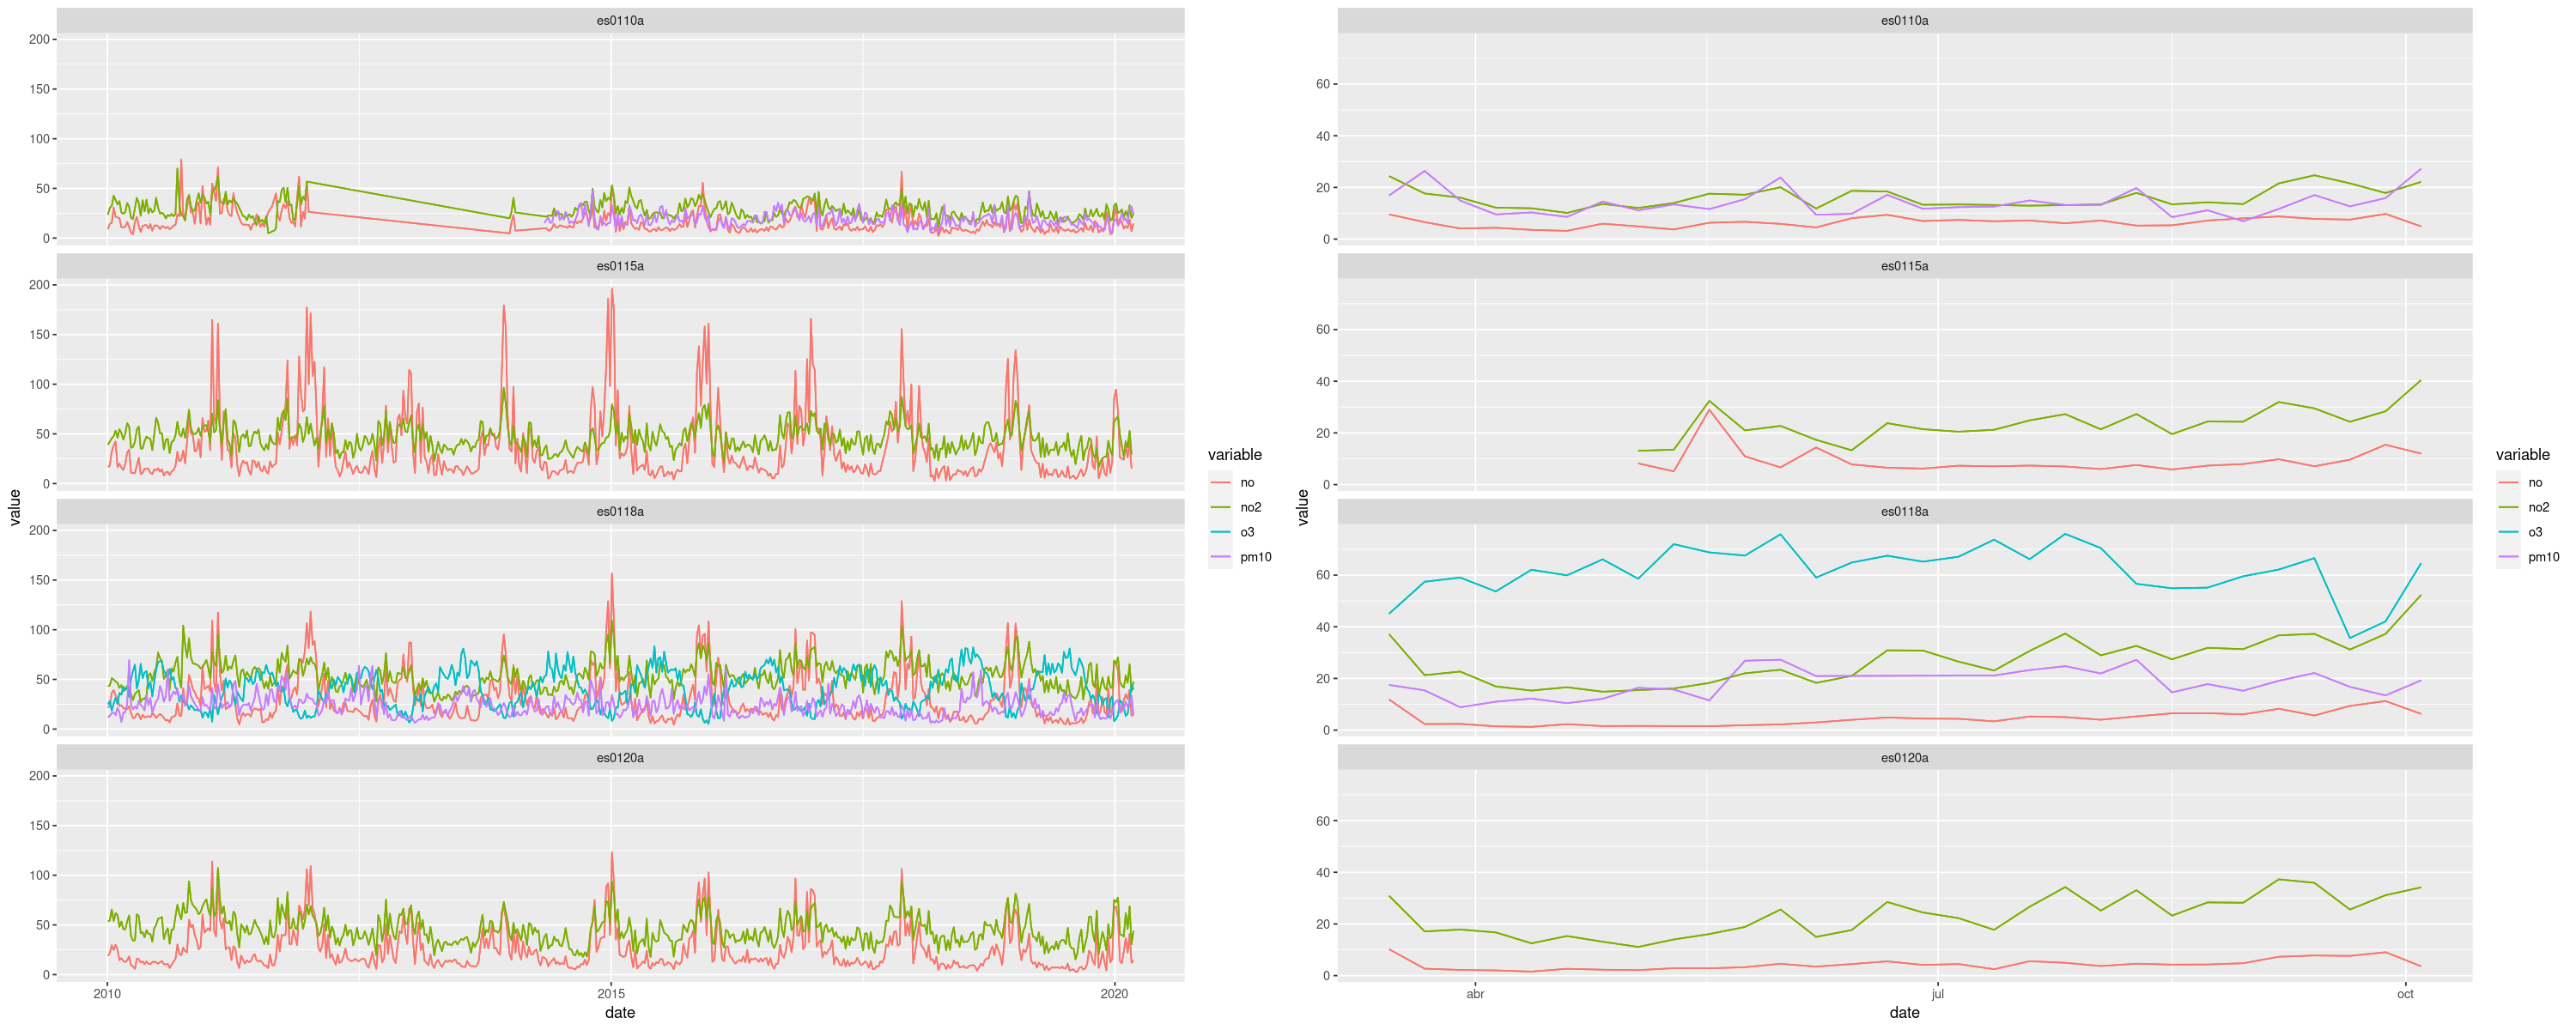

In [16]:
preCOVID <- ggplot(data = group.wk[group.wk$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.wk[group.wk$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

### Resolucion de 1 mes <a id="resoms"></a>

In [17]:
group.mth <- group.by.date(dataAQV, by="month", FUN="mean")

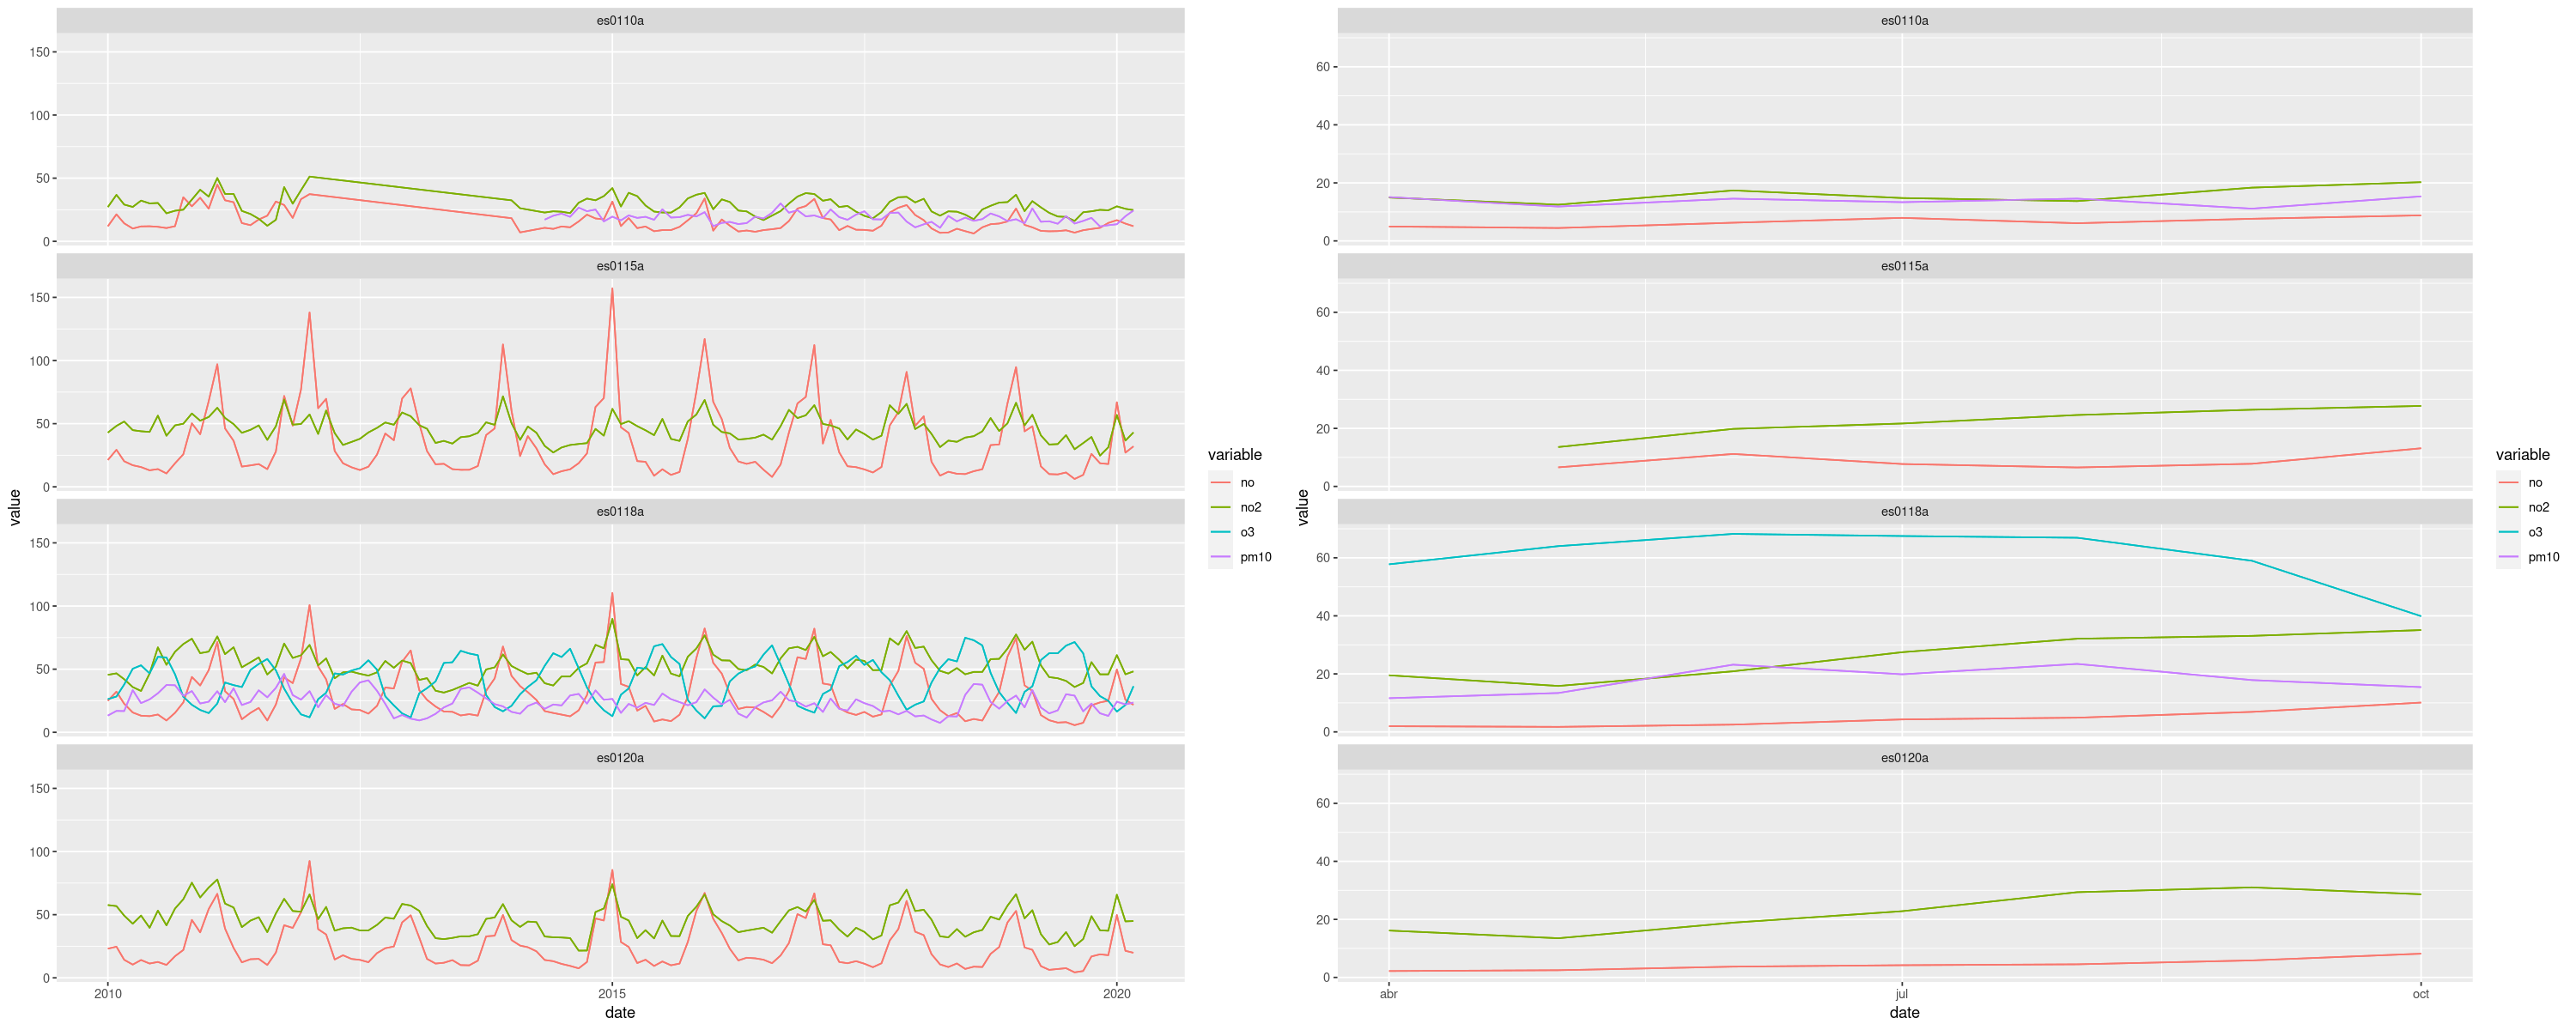

In [18]:
preCOVID <- ggplot(data = group.mth[group.mth$date < lckdwn_strt, ], 
                   aes(x = date, y = value, color=variable)
                  ) +
                geom_line() +
                geom_line() + 
                facet_wrap(~site, ncol=1)

COVID <- ggplot(data = group.mth[group.mth$date > lckdwn_strt, ],
                aes(x = date, y = value, color=variable)
               ) +
               geom_line() +
               geom_line() +
               facet_wrap(~site, ncol=1)
    
grid.arrange(preCOVID, COVID, nrow = 1)

## Analisis de los Datos <a id="analyData"></a>

Se aplican algunas funciones propias de `R` para mostrar el potencial de los datos combinandolos con paquetes estadisticos existentes

### Theil-Sen function <a id="theilSen"></a>

Se comparan las graficas obtenidas mediante la funcion propia de `Openair` para el estimador Theil-Sein y las obtenidas mediante otro metodo externo.

In [9]:
test.theilSen <- pivot.by.pollut(dataAQV, 
                             pollutants=pollutants, 
                             by="week",
                             #site=sites$site[3]
                            )

test.theilSen$fit <- rep(0, nrow(test.theilSen))
for (site in levels(as.factor(test.theilSen$site))) {

    fit <- mblm(no2 ~ id + 1, 
                test.theilSen[test.theilSen$site == site, ], 
                repeated=T)
    test.theilSen[test.theilSen$site == site, ]$fit <- fit$fitted.values
}

Warning message:
“`group_by_()` is deprecated as of dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`summarise_each_()` is deprecated as of dplyr 0.7.0.
Please use `across()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Taking bootstrap samples. Please wait."
[1] "Takin

Warning message:
“`distinct_()` is deprecated as of dplyr 0.7.0.
Please use `distinct()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message:
“Removed 134 rows containing missing values (geom_point).”
Warning message:
“Removed 873 rows containing missing values (geom_point).”
Warning message:
“Removed 319 row(s) containing missing values (geom_path).”
Warning message:
“Removed 19291 row(s) containing missing values (geom_path).”
Warning message:
“Removed 134 rows containing missing values (geom_point).”


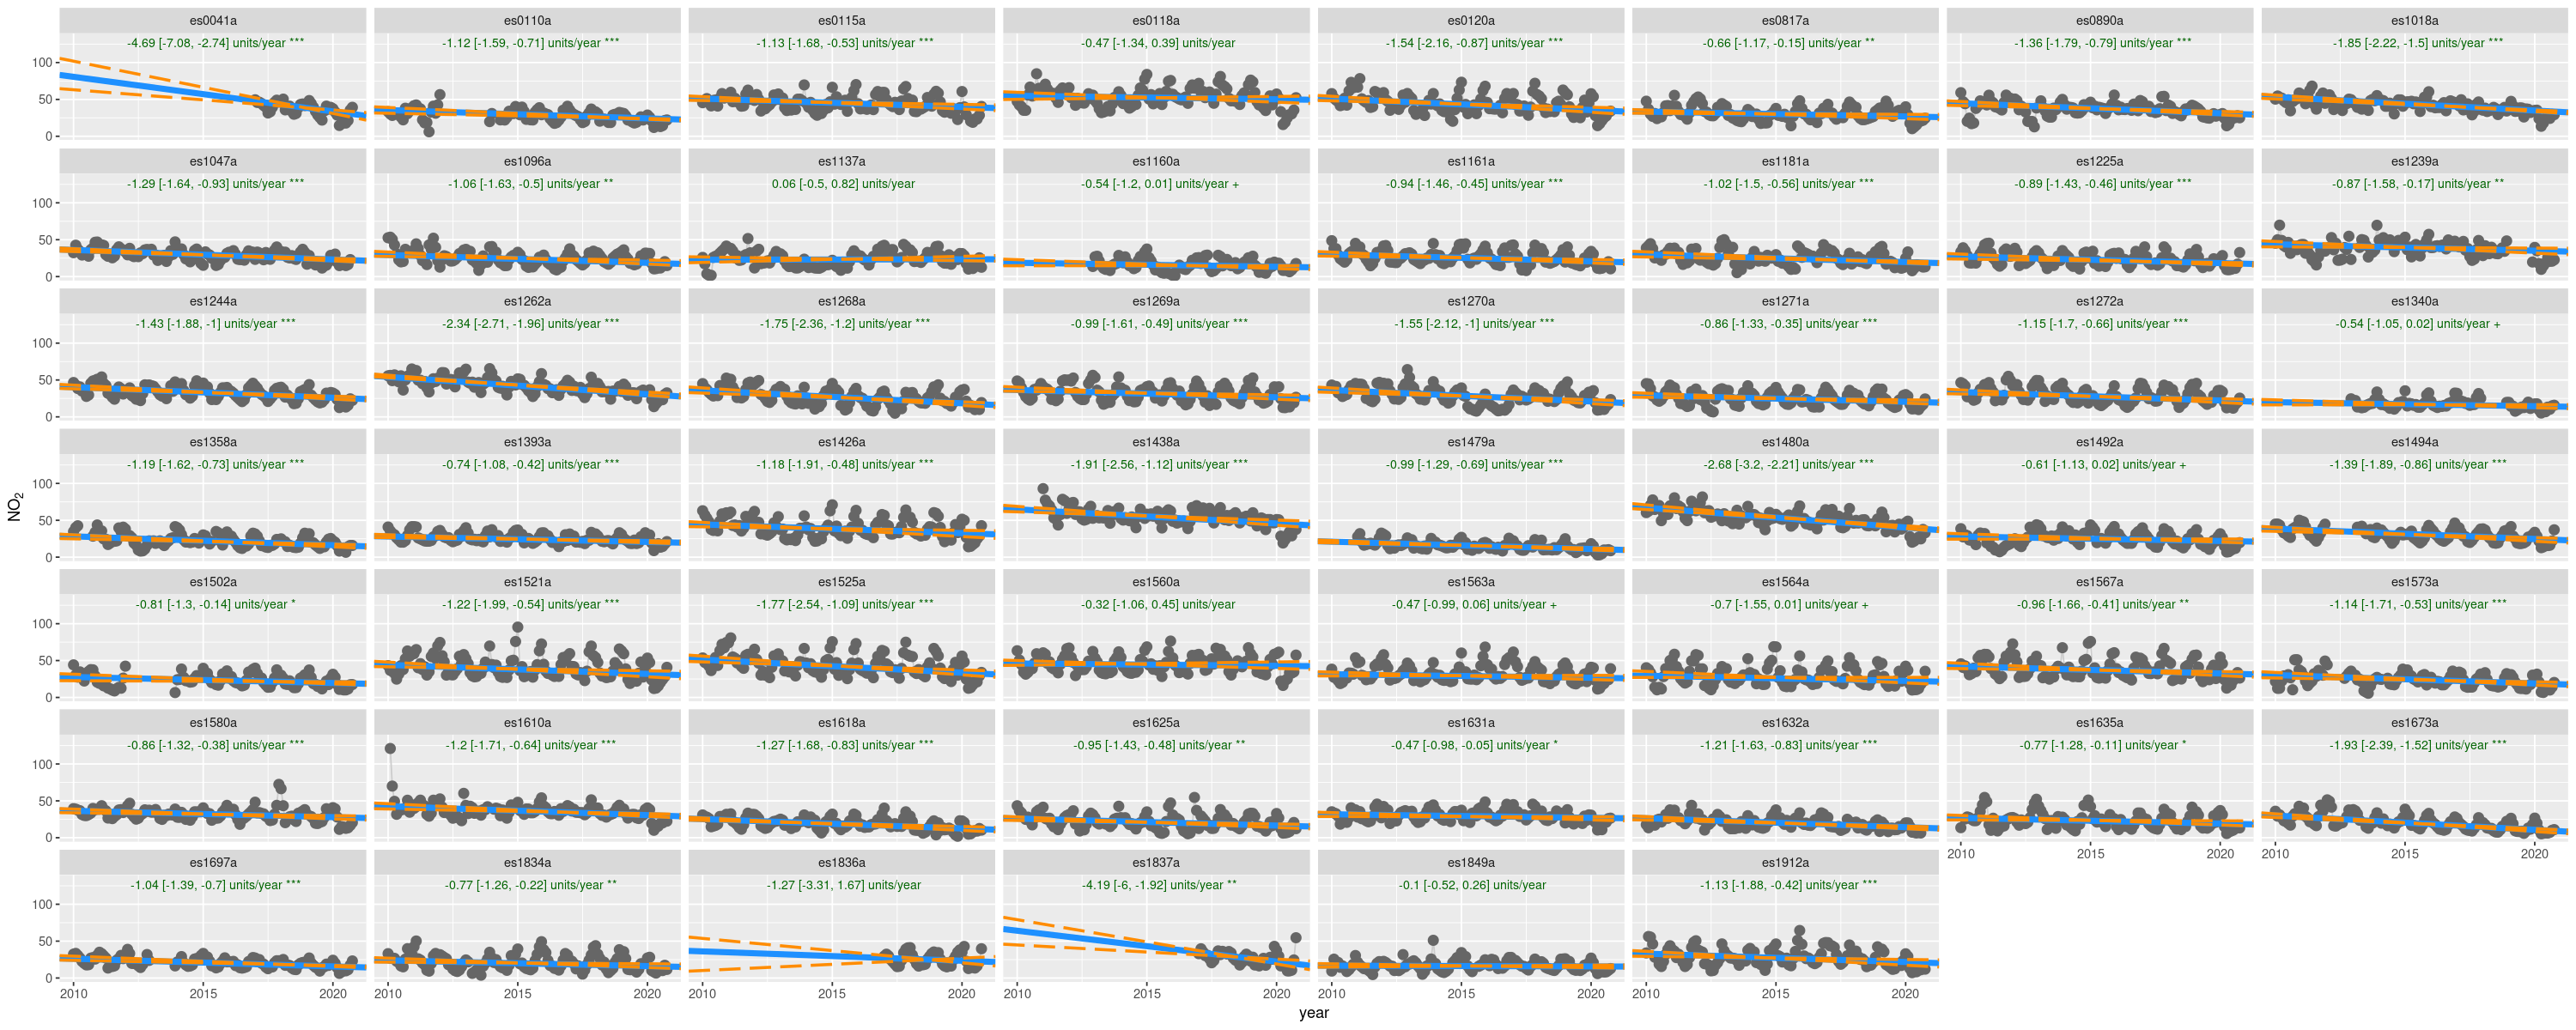

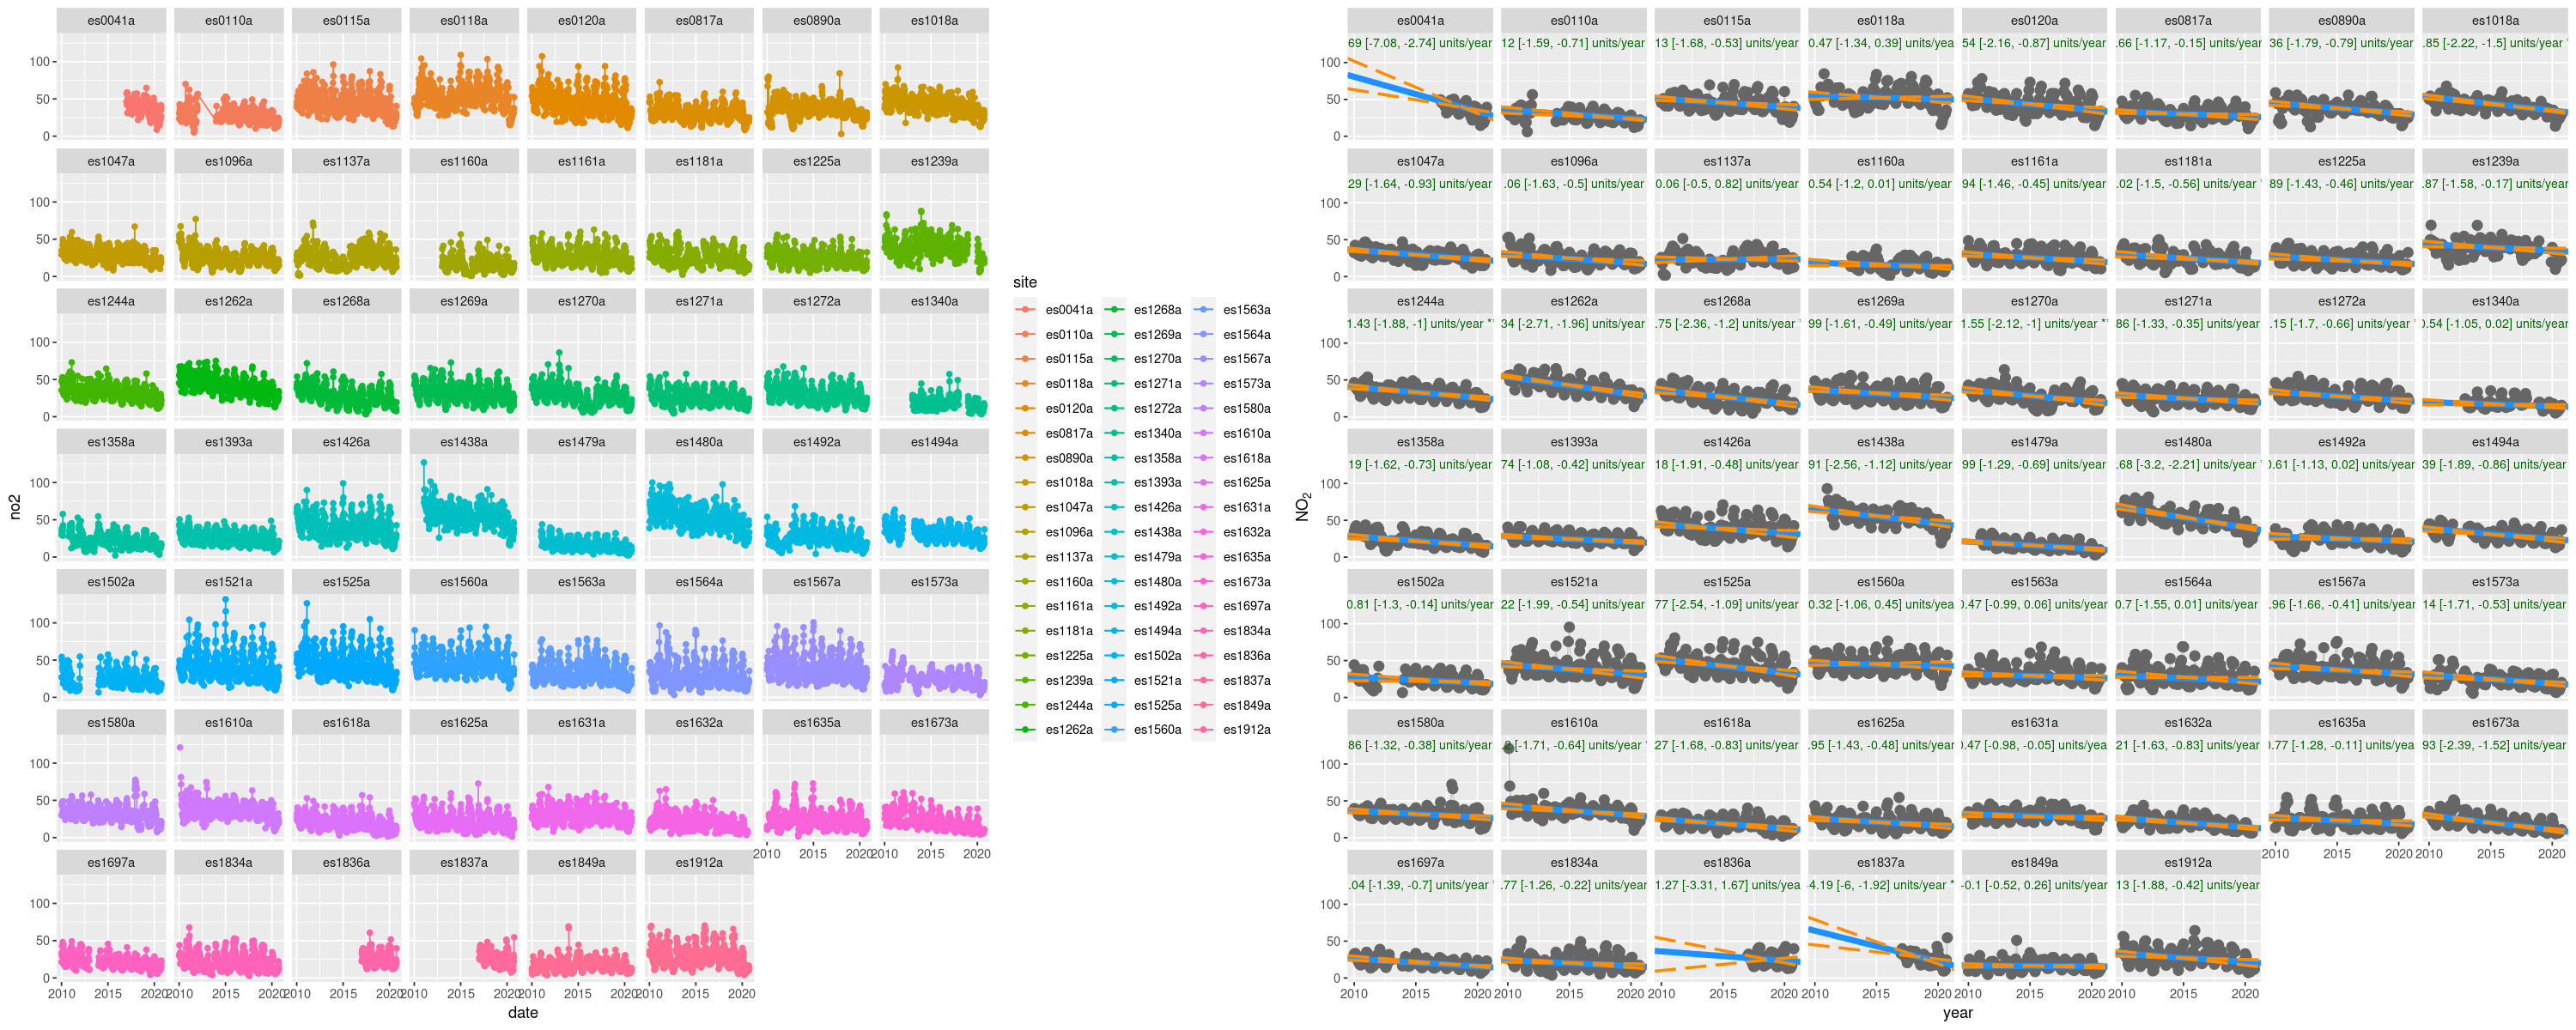

In [10]:
my.plt <- ggplot(data=test.theilSen, aes(x=date)) +
                geom_point(aes(y=no2, color=site)) +
                geom_line(aes(y=no2, color=site)) +
                geom_line(aes(y=fit, color=site))  +
                facet_wrap(~site)

theil.plt <- suppressMessages(TheilSen(test.theilSen,
                                       deseason = F,
                                       pollutant = "no2", 
                                       #site=sites$site[3],
                                       avg.time = "month",
                                       type="site",
                                      )
                              )


grid.arrange(my.plt, theil.plt$plot, nrow = 1)

### Funcion `lm` <a id="lm"></a>

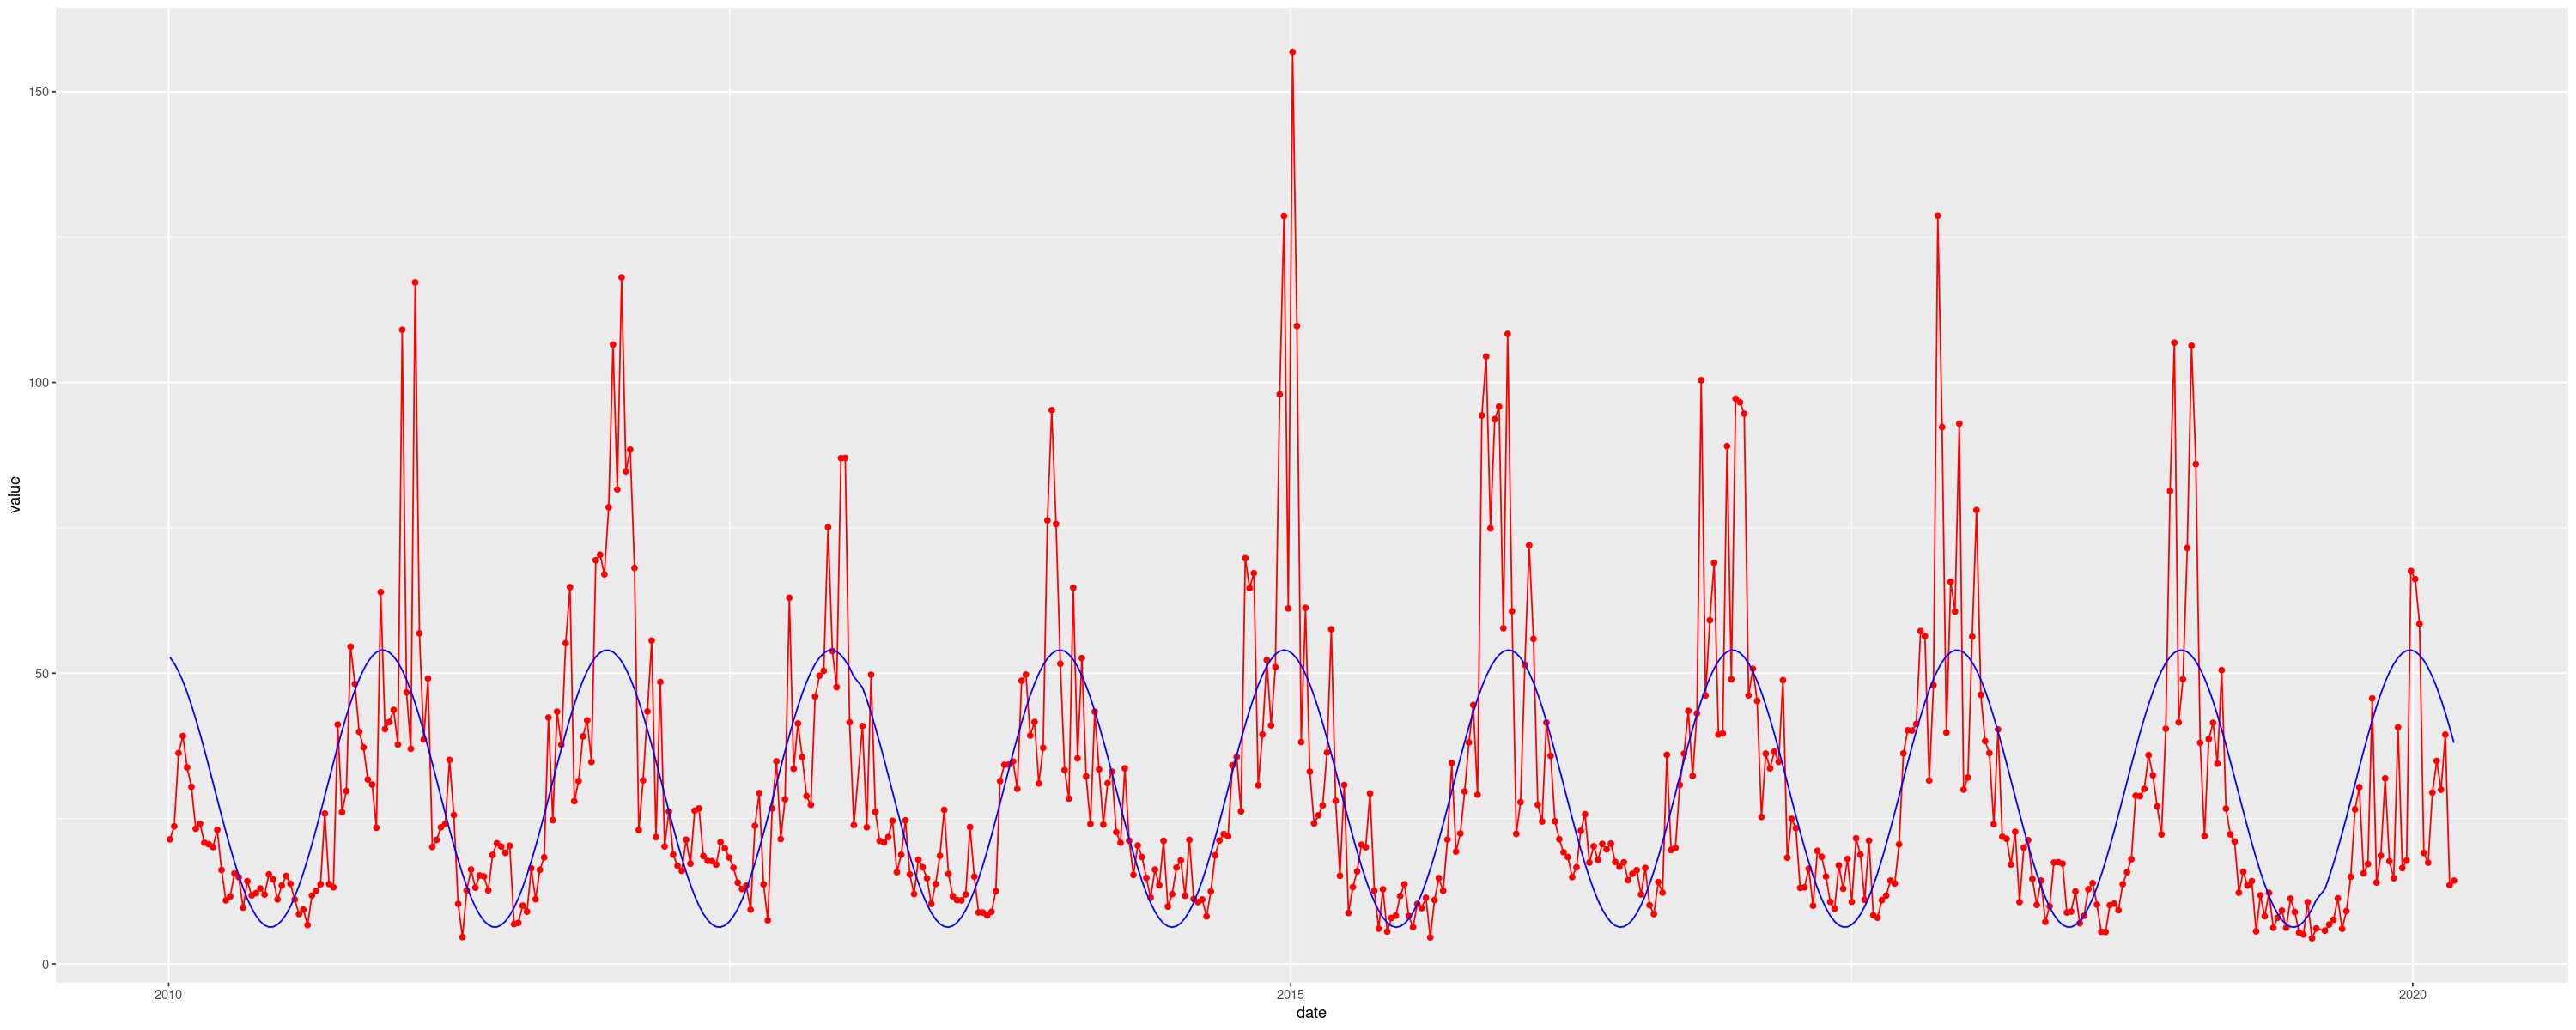

In [58]:
data.lm <- group.wk[group.wk$site ==  "es0118a"
                    & group.wk$variable == "no",][ c("value", "date")]
data.lm["id"] <- seq.int(nrow(data.lm))

preCOVID <- data.lm[data.lm$date <= lckdwn_strt, ]

lm.fit <- lm(value ~ sin(2*pi/(1*52.1429)*id)+cos(2*pi/(1*52.1429)*id), 
                data=preCOVID)

ggplot() + 
        geom_point(data=preCOVID, aes(x=date, y=value), color="red") +
        geom_line(data=preCOVID, aes(x=date, y=value), color="red") +
        geom_line(aes(x=preCOVID$date, y=lm.fit$fitted.values), color="blue")

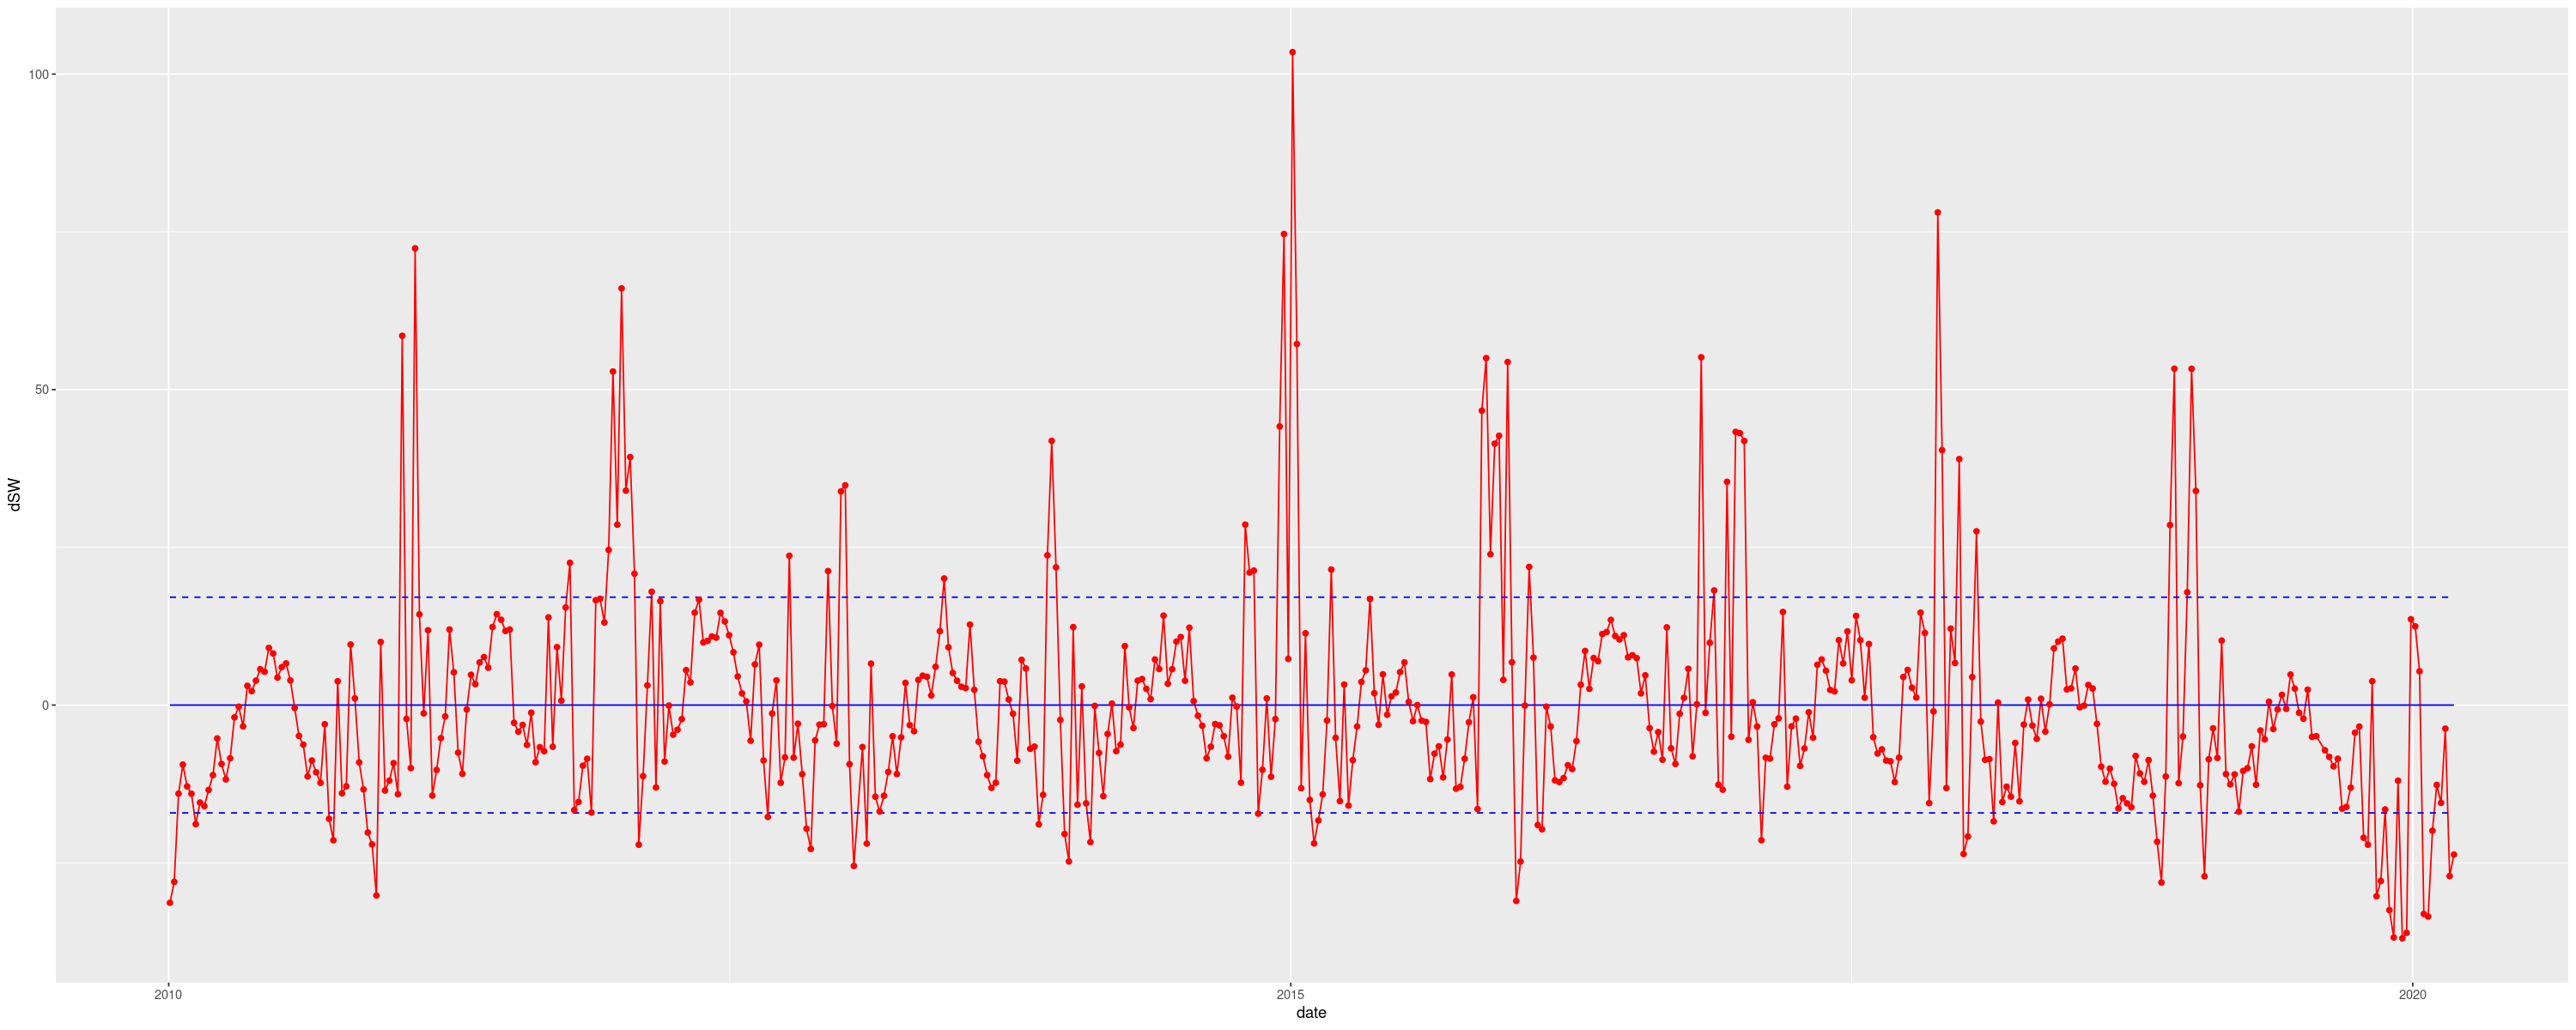

In [59]:
preCOVID$dSW <- preCOVID$value - lm.fit$fitted.values

ggplot() + 
        geom_line(data=preCOVID, aes(x=date, y=dSW), color="red") +
        geom_line(data=preCOVID, aes(x=date, y=mean(dSW)), color="blue") +
        geom_line(data=preCOVID, aes(x=date, y=mean(dSW)+sd(dSW)), color="blue", linetype = "dashed") +
        geom_line(data=preCOVID, aes(x=date, y=mean(dSW)-sd(dSW)), color="blue", linetype = "dashed") +
        geom_point(data=preCOVID, aes(x=date, y=dSW), color="red")

In [64]:
preCOVID$wk.yr <- week(preCOVID$date)
COVID$wk.yr <- week(COVID$date)

jaime <- aggregate(dSW ~ wk.yr, preCOVID, "mean")
diez <- aggregate(dSW ~ wk.yr, COVID, "mean")

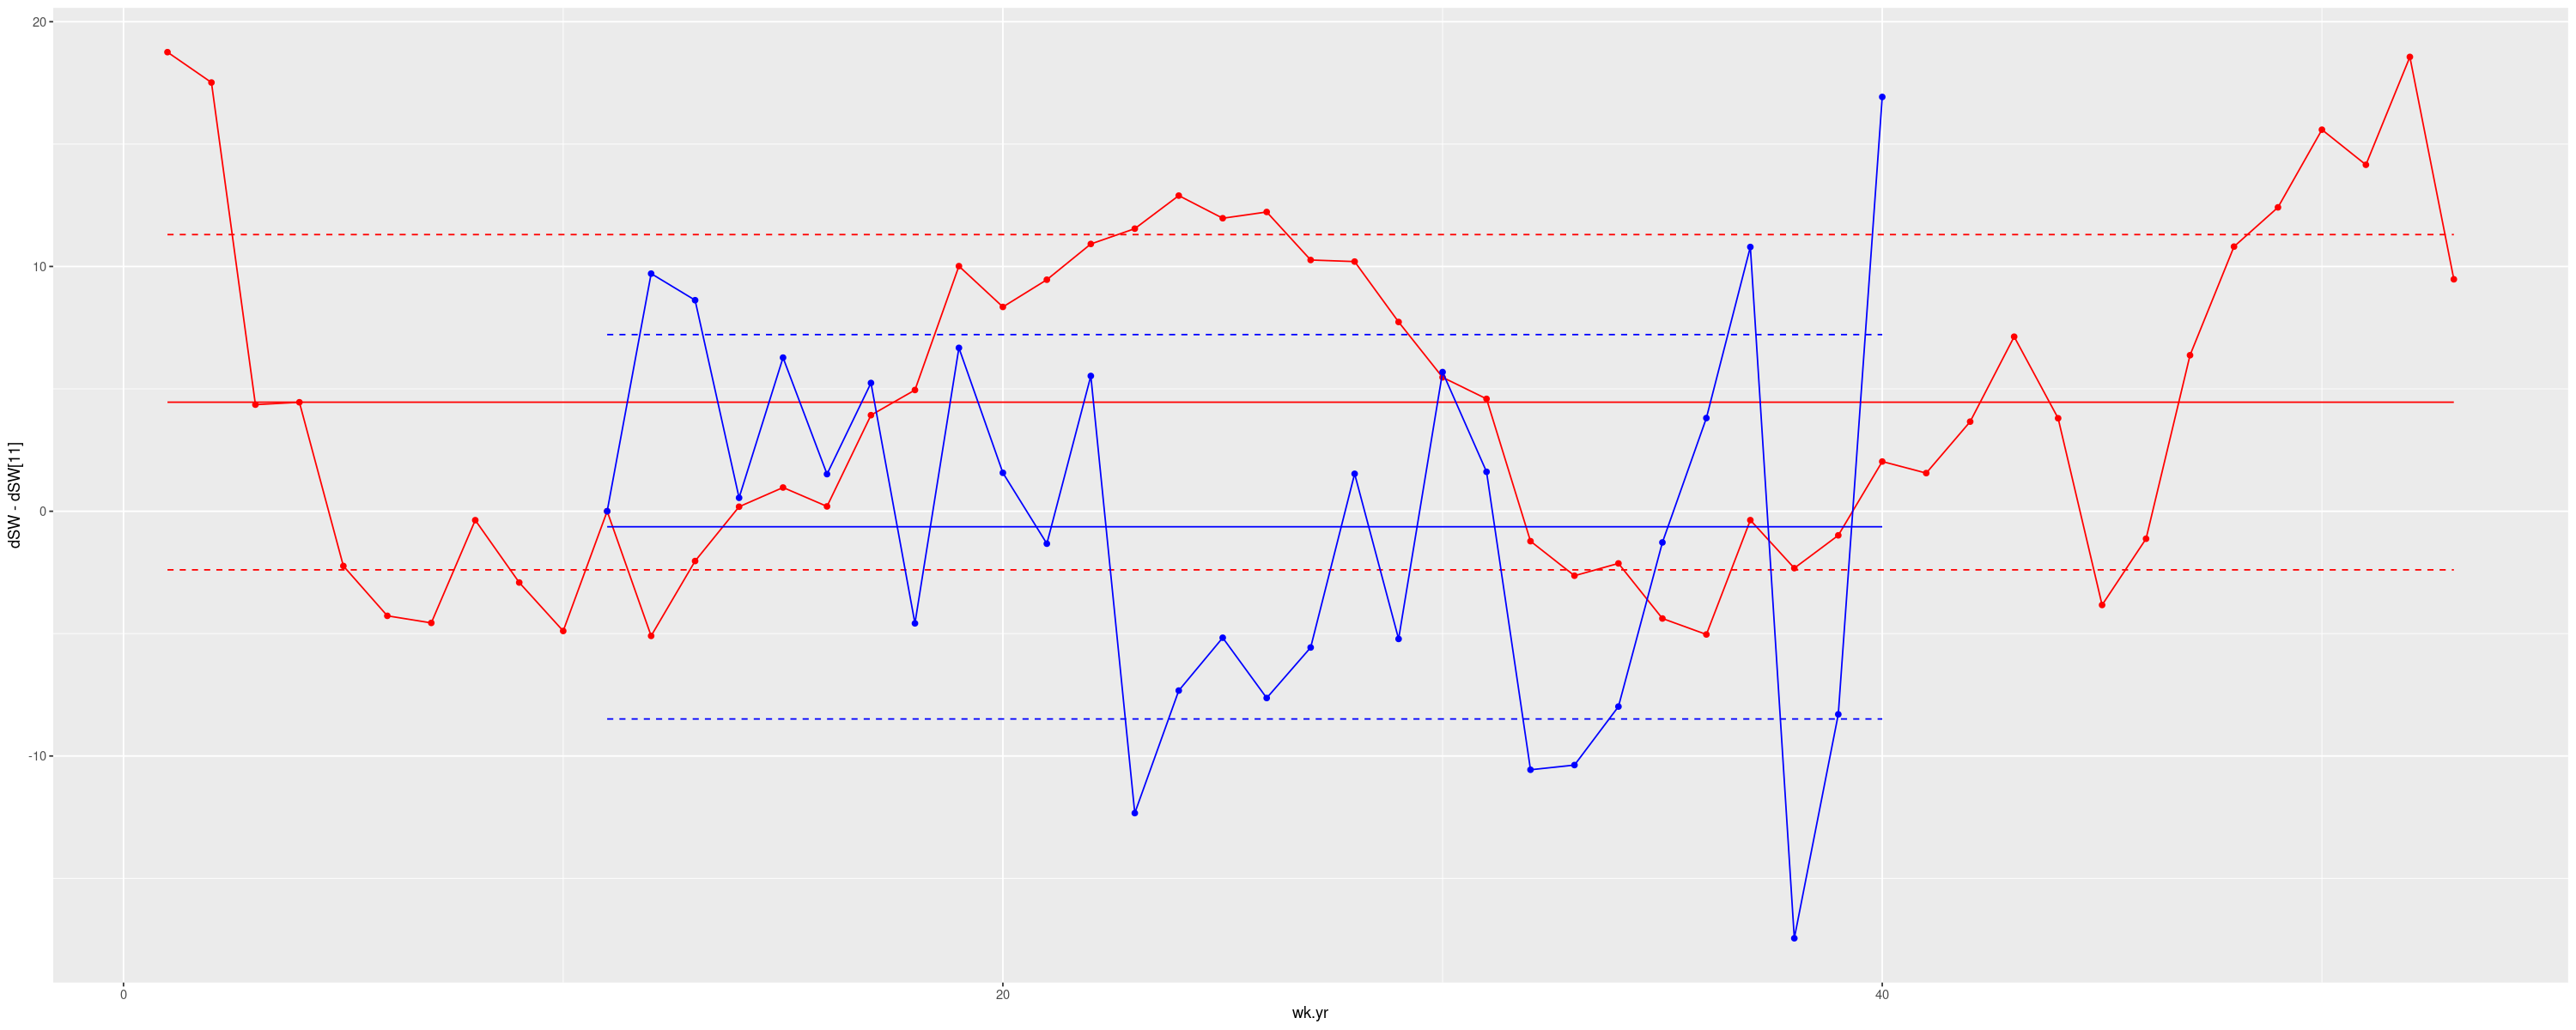

In [69]:
ggplot() + 
        geom_line(data=jaime, aes(x=wk.yr, y=dSW-dSW[11]), color="red") +
        geom_line(data=jaime, aes(x=wk.yr, y=mean(dSW)-dSW[11]), color="red") +
        geom_line(data=jaime, aes(x=wk.yr, y=mean(dSW)+sd(dSW)-dSW[11]), color="red", linetype = "dashed") +
        geom_line(data=jaime, aes(x=wk.yr, y=mean(dSW)-sd(dSW)-dSW[11]), color="red", linetype = "dashed") +
        geom_point(data=jaime, aes(x=wk.yr, y=dSW-dSW[11]), color="red") +

        geom_line(data=diez, aes(x=wk.yr, y=dSW-dSW[1]), color="blue") +
        geom_line(data=diez, aes(x=wk.yr, y=mean(dSW)-dSW[1]), color="blue") +
        geom_line(data=diez, aes(x=wk.yr, y=mean(dSW)+sd(dSW)-dSW[1]), color="blue", linetype = "dashed") +
        geom_line(data=diez, aes(x=wk.yr, y=mean(dSW)-sd(dSW)-dSW[1]), color="blue", linetype = "dashed") +
        geom_point(data=diez, aes(x=wk.yr, y=dSW-dSW[1]), color="blue")

## Guardar Datos en xlsx <a id="save"></a>

``` R
write.csv(dataAQV, "../data/csv/dataAQV.csv", row.names=FALSE)
write.csv(sites, "../data/csv/estaciones.csv", row.names=FALSE)
```